In [ ]:
!pip install qiskit
!pip install qiskit-aer

# Solving combinatorial optimization problems using QAOA

In this tutorial we explain approximate optimization algorithms, explain how the Quantum Approximate Optimization Algorithm (QAOA) works and present the implementation of an example.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

## Combinatorial Optimization Problem

Combinatorial optimization problems involve finding an optimal object out of a finite set of objects. We would focus on problems that involve
finding "optimal" bitstrings composed of 0's and 1's among a finite set of bitstrings. One such problem corresponding to a graph is the Max-Cut problem.

### Max-Cut problem
A Max-Cut problem involves partitioning nodes of a graph into two sets, such that the number of edges between the sets is maximum. The example below
has a graph with four nodes and some of the ways in which it can be partitioned into two sets, "red" and "blue" is shown.

qaoa_maxcut.svg

For 4 nodes, as each node can be assigned to either the "red" or "blue" sets, there are  $2^4=16$  possible assigments, out of which we have to find one that gives maximum number of edges between the sets "red" and "blue". The number of such edges between two sets in the figure, as we go from left to right, are 0, 2, 2, and 4. We can see, after enumerating all possible $2^4=16$ assignments, that the rightmost figure is the assignment that gives the maximum number of edges between the two sets. Hence if we encode "red" as 0 and "blue" as 1, the bitstrings "0101" and "1010" that represent the assignment of nodes to either set are the solutions.   

As you may have realized, as the number of nodes in the graph increases, the number of possible assignments
that you have to examine to find the solution increases exponentially.

## QAOA

QAOA (Quantum Approximate Optimization Algorithm) introduced by Farhi et al.[1] is a quantum algorithm that attempts to
solve such combinatorial problems.<br>

It is a variational algorithm that uses a unitary $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ characterized by the parameters
$(\boldsymbol{\beta}, \boldsymbol{\gamma})$ to prepare a quantum state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$.
The goal of the algorithm
is to find optimal parameters $(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt})$ such that the
quantum state $\lvert \psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rangle$ encodes the solution to the problem.

The unitary $U(\boldsymbol{\beta}, \boldsymbol{\gamma})$ has a specific form and is composed of two unitaries
$U(\boldsymbol{\beta}) = e^{-i \boldsymbol{\beta} H_B}$ and $U(\boldsymbol{\gamma}) = e^{-i \boldsymbol{\gamma} H_P}$
where $H_B$ is the mixing Hamiltonian and $H_P$ is the problem Hamiltonian. Such a choice of unitary drives its inspiration
from a related scheme called quantum annealing.

The state is prepared by applying these unitaries as alternating blocks of the two unitaries applied $p$ times such that

$$\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle = \underbrace{U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})
                                            \cdots U(\boldsymbol{\beta}) U(\boldsymbol{\gamma})}_{p \; \text{times}}
\lvert \psi_0 \rangle$$

where $\lvert \psi_0 \rangle$ is a suitable initial state.

We will demonstrate these steps using the Max-Cut problem discussed above. For that we would first define
the underlying graph of the problem shown above.

In [ ]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

The problem Hamiltonian specific to the Max-Cut problem up to a constant here is:

$$
H_P = \frac{1}{2}\big(Z_0 \otimes Z_1 \otimes I_2 \otimes I_3\big) +
        \frac{1}{2}\big(I_0 \otimes Z_1 \otimes Z_2 \otimes I_3\big) +
        \frac{1}{2}\big(Z_0 \otimes I_1 \otimes I_2 \otimes Z_3\big) +
        \frac{1}{2}\big(I_0 \otimes I_1 \otimes Z_2 \otimes Z_3\big)
$$

To contruct such a Hamiltonian for a problem, one needs to follow a few steps that we'll cover in later sections of this page.

The mixer Hamiltonian $H_B$ is usually of the form:

$$
H_B = \big(X_0 \otimes I_1 \otimes I_2 \otimes I_3 \big) +
      \big(I_0 \otimes X_1 \otimes I_2 \otimes I_3 \big) +
      \big(I_0 \otimes I_1 \otimes X_2 \otimes I_3 \big) +
      \big(I_0 \otimes I_1 \otimes I_2 \otimes X_3 \big)
$$

As individual terms in the summation of $H_P$ and $H_B$ both commute, we can write the unitaries as:

$$ U(H_B) = e^{-i \beta H_B} = e^{-i \beta X_0}e^{-i \beta X_1}e^{-i \beta X_2}e^{-i \beta X_3}.$$

Notice that each term in the product above corresponds to an X-rotation on each qubit. And we can write $U(H_P)$ as:

$$ U(H_P) = e^{-i \gamma H_P} = e^{-i \gamma Z_0 Z_1}e^{-i \gamma Z_1 Z_2}e^{-i \gamma Z_2 Z_3}e^{-i \gamma Z_0 Z_3}$$

Let's now examine what the circuits of the two unitaries look like.

### The Mixing Unitary

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import Aer, AerSimulator
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)

qc_mix.draw()

### The Problem Unitary

In [ ]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.decompose().draw()

### The Initial State

The initial state used during QAOA is usually an equal superposition of all the basis states i.e.

$$\lvert \psi_0 \rangle = \bigg(\frac{1}{\sqrt{2}}\big(\lvert 0 \rangle + \lvert 1 \rangle\big)\bigg)^{\otimes n}$$

Such a state, when number of qubits is 4 ($n=4$), can be prepared by applying Hadamard gates starting from an all zero state as shown in
the circuit below.

In [ ]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)

qc_0.draw()

### The QAOA circuit

So far we have seen that the preparation of a quantum state during QAOA is composed of three elements
- Preparing an initial state
- Applying the unitary $U(H_P) = e^{-i \gamma H_P}$ corresponding to the problem Hamiltonian
- Then, applying the mixing unitary $U(H_B) = e^{-i \beta H_B}$

Let's see what it looks like for the example problem:

In [ ]:
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw()

The next step is to find the optimal parameters $(\boldsymbol{\beta_{opt}}, \boldsymbol{\gamma_{opt}})$ such that the expectation value

$$ \langle \psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rvert H_P \lvert
\psi(\boldsymbol{\beta}_{opt}, \boldsymbol{\gamma}_{opt}) \rangle $$

is minimized. Such an expectation can be obtained by doing measurement in the Z-basis. We use a classical optimization algorithm to find the optimal parameters. Following steps are involved as shown in the schematic

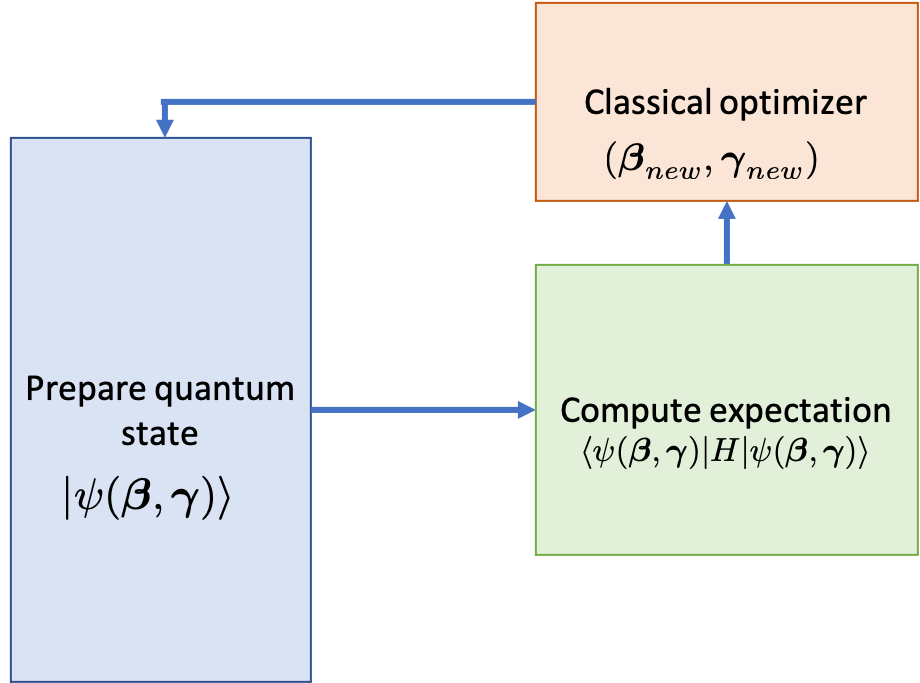

1. Initialize $\boldsymbol{\beta}$ and $\boldsymbol{\gamma}$ to suitable real values.
2. Repeat until some suitable convergence criteria is met:
    1. Prepare the state $\lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle$ using qaoa circuit
    2. Measure the state in standard basis
    3. Compute $ \langle \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rvert H_P \lvert \psi(\boldsymbol{\beta}, \boldsymbol{\gamma}) \rangle $
    4. Find new set of parameters $(\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})$ using a classical optimization algorithm
    5. Set current parameters $(\boldsymbol{\beta}, \boldsymbol{\gamma})$ equal to the new parameters
      $(\boldsymbol{\beta}_{new}, \boldsymbol{\gamma}_{new})$

The code below implements the steps mentioned above.

In [ ]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.

    Args:
        x: str
           solution bitstring

        G: networkx graph

    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1

    return obj


def compute_expectation(counts, G):

    """
    Computes expectation value based on measurement results

    Args:
        counts: dict
                key as bitstring, val as count

        G: networkx graph

    Returns:
        avg: float
             expectation value
    """

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():

        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count

    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):

    """
    Creates a parametrized qaoa circuit

    Args:
        G: networkx graph
        theta: list
               unitary parameters

    Returns:
        qc: qiskit circuit
    """

    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)

    beta = theta[:p]
    gamma = theta[p:]

    # initial_state
    for i in range(0, nqubits):
        qc.h(i)

    for irep in range(0, p):

        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)

    qc.measure_all()

    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=512):

    """
    Runs parametrized circuit

    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """

    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):

        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()

        return compute_expectation(counts, G)

    return execute_circ

In [ ]:
from scipy.optimize import minimize


expectation = get_expectation(G)

res = minimize(expectation,
                      [1.0, 1.0],
                      method='COBYLA')
res

Note that different choices of classical optimizers are present in qiskit. We choose [COBYLA](https://github.com/Qiskit/qiskit-terra/blob/main/qiskit/algorithms/optimizers/cobyla.py) as our classical optimization algorithm here.

### Analyzing the result

In [ ]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

As we notice that the bitstrings "0101" and "1010" have the highest probability and are indeed the assignments of the graph (we started with) that gives 4 edges between the two partitions.

## References<a id="references"></a>
1. Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint [arXiv:1411.4028 (2014)](https://arxiv.org/abs/1411.4028).
2. Goemans, Michel X., and David P. Williamson. [Journal of the ACM (JACM) 42.6 (1995): 1115-1145](http://www-math.mit.edu/~goemans/PAPERS/maxcut-jacm.pdf).
3. Garey, Michael R.; David S. Johnson (1979). Computers and Intractability: A Guide to the Theory of NP-Completeness. W. H. Freeman. ISBN 0-7167-1045-5
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." [Nature 549.7671 (2017): 242](https://www.nature.com/articles/nature23879).
5. Farhi, Edward, et al. "Quantum algorithms for fixed qubit architectures." arXiv preprint [arXiv:1703.06199 (2017)](https://arxiv.org/abs/1703.06199).
6. Spall, J. C. (1992), [IEEE Transactions on Automatic Control, vol. 37(3), pp. 332–341](https://ieeexplore.ieee.org/document/119632).
7. Michael Streif and Martin Leib "Training the quantum approximate optimization algorithm without access to a quantum processing unit" (2020) [Quantum Sci. Technol. 5 034008](https://doi.org/10.1088/2058-9565/ab8c2b)